In [14]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path('..').resolve()
print('Project root:', project_root)

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.data.load_fraud_data import load_fraud_data
from uais.features.fraud_features import build_fraud_feature_table


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [15]:
df_raw = load_fraud_data()
print('Raw fraud data shape:', df_raw.shape)
df_raw.head()


Raw fraud data shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
df_raw.info()

print('Class balance (0 = non-fraud, 1 = fraud):')
print(df_raw['Class'].value_counts())
print('Fraud ratio:', df_raw['Class'].mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

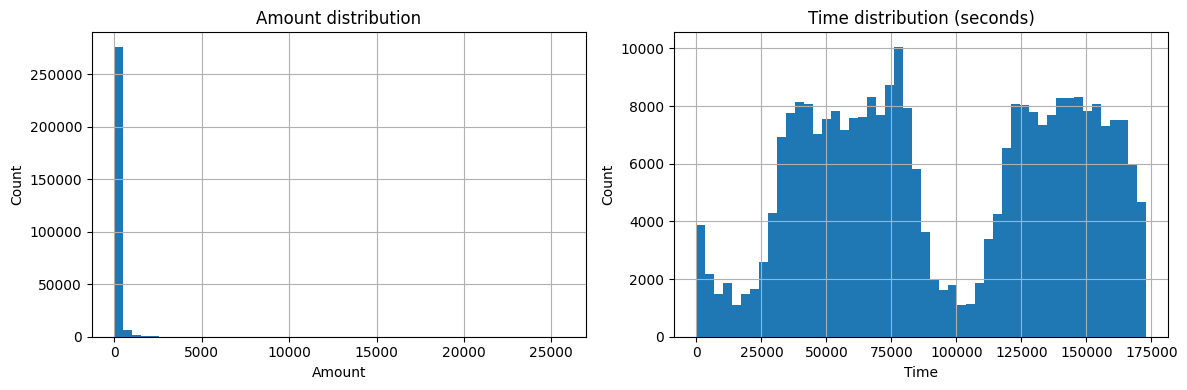

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df_raw['Amount'].hist(ax=axes[0], bins=50)
axes[0].set_title('Amount distribution')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Count')

df_raw['Time'].hist(ax=axes[1], bins=50)
axes[1].set_title('Time distribution (seconds)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [18]:
df_feats = build_fraud_feature_table(
    df_raw,
    time_column='Time',
    amount_column='Amount',
    target_column='Class',
    drop_original_time=False,
)

print('Feature table shape:', df_feats.shape)
df_feats.head()


Feature table shape: (284807, 35)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,amount_log,time_hours,time_seconds_mod_day,hour_of_day
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.014760,0.000000,0.0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,1.305626,0.000000,0.0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.939276,0.000278,1.0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.824306,0.000278,1.0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.262539,0.000556,2.0,0


In [19]:
processed_dir = project_root / 'data' / 'processed' / 'fraud'
processed_dir.mkdir(parents=True, exist_ok=True)

feats_path = processed_dir / 'fraud_features.parquet'
df_feats.to_parquet(feats_path)

print('Saved feature table to:', feats_path)


Saved feature table to: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/data/processed/fraud/fraud_features.parquet
